# Pràctica LP

## Baixar i tractar les dades

In [1]:
import pandas as pd

In [2]:
import networkx as nx

In [3]:
from haversine import haversine

In [226]:
from staticmap import StaticMap, Line, CircleMarker

In [41]:
from fuzzywuzzy import fuzz

/Users/roger.romero/Desktop/Uni/FIB/LP/PracticaPython/practica/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [279]:
import telegram
from telegram.ext import Updater
from telegram.ext import CommandHandler

In [6]:
URL = 'https://github.com/jordi-petit/lp-graphbot-2019/blob/master/dades/worldcitiespop.csv.gz?raw=true'

In [7]:
COLUMNS = {
    'Country': 0,
    'AccentCity': 1,
    'Region': 2,
    'Population': 3,
    'Latitude': 4,
    'Longitude': 5
}

In [8]:
MIN_POPULATION = 100000
MAX_DISTANCE = 300
CIRCLE_SCALE = 0.000005

## Pandas

In [15]:
import gzip

In [9]:
import time
start_time = time.time()
dataframe = pd.read_csv('data/citydata.csv.gz', usecols=COLUMNS.keys(), compression='gzip')

/Users/roger.romero/Desktop/Uni/FIB/LP/PracticaPython/practica/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [44]:
dataframe.head()

,Country,AccentCity,Region,Population,Latitude,Longitude
0,ad,Aixàs,6,NaN,42.483333,1.466667
1,ad,Aixirivali,6,NaN,42.466667,1.500000
2,ad,Aixirivall,6,NaN,42.466667,1.500000
3,ad,Aixirvall,6,NaN,42.466667,1.500000
4,ad,Aixovall,6,NaN,42.466667,1.483333


In [65]:
dataframe[dataframe['AccentCity']=='Madrid']

,Country,AccentCity,Region,Population,Latitude,Longitude
873329,es,Madrid,29,3102644.0,40.408566,-3.69222


In [66]:
0.000005*3102644

15.51322

In [10]:
dataframe = dataframe[dataframe['Population']>100000]

In [11]:
len(dataframe)

3527

In [ ]:
dataframe

In [12]:
start_time = time.time()
coordinates = dict()
coordinate_to_city = dict()
populations = dict()
for row in dataframe.iterrows():
    info = row[1]
    city = info[COLUMNS['AccentCity']]
    country = info[COLUMNS['Country']]
    region = info[COLUMNS['Region']]
    key = '{city}, {country}; {region}'.format(
        city=city,
        country=country,
        region=region
    )
    coordinates[key] = (
        info[COLUMNS['Latitude']],
        info[COLUMNS['Longitude']]
    )
    coordinate_to_city[(info[COLUMNS['Latitude']],info[COLUMNS['Longitude']])] = key.split(';')[0]
    populations[key] = info[COLUMNS['Population']]
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.6108977794647217 seconds ---


In [10]:
len(coordinates)

3527

## CSV 

In [25]:
import csv
import gzip

In [53]:
import requests

In [4]:
r = requests.get(URL)

In [5]:
open('data/citydata.csv.gz', 'wb').write(r.content)

43873807

In [26]:
def process_row(row):
    '''
    Processes a row in the csv
    '''
    country, _, city, region, pop, lat, lon = row
    code = '{city}, {country}; {region}'.format(
        city=city,
        country=country,
        region=region
    )
    if pop == '':
        pop = 0
    elif '.' in pop:
        pop = pop.split('.')[0]
    return code, (float(lat), float(lon)), int(pop)

In [55]:
start_time = time.time()
coordinates = dict()
populations = dict()

with gzip.open('data/citydata.csv.gz', 'rt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count != 0:
            city, coords, pop = process_row(row)
            if pop >= 100000:
                coordinates[city] = coords
                populations[city] = pop
        line_count += 1
print("--- %s seconds ---" % (time.time() - start_time))

--- 10.696715116500854 seconds ---


In [31]:
populations['Barcelona, es; ']

KeyError: 'Barcelona, es'

In [21]:
with gzip.open('citydata.csv.gz', 'rt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        

## Crear el graf

In [218]:
G = nx.Graph()

In [219]:
for city in coordinates.keys():
    G.add_node(city)

In [151]:
def get_distance(coordsa, coordsb):
    return haversine(coordsa, coordsb)

In [227]:
def get_city_distance(citya, cityb):
    return get_distance(coordinates[citya], coordinates[cityb])

In [220]:
start_time = time.time()
for city_a in coordinates.keys():
    for city_b in coordinates.keys():
        distance = get_city_distance(city_a, city_b)
        if city_a != city_b and distance <= MAX_DISTANCE:
            G.add_edge(city_a, city_b, weight=distance)
print("--- %s seconds ---" % (time.time() - start_time))

--- 33.85638999938965 seconds ---


In [ ]:
for edge in G.edges:
    print(edge)
    break

In [229]:
def is_plottable(edge, coords, dist):
    dist0 = get_distance(coordinates[edge[0]], coords)
    dist1 = get_distance(coordinates[edge[1]], coords)
    return dist0 <= dist and dist1 <= dist

def plotgraph(lat, long, dist):
    mapa = StaticMap(400, 400)
    for edge in G.edges:
        if is_plottable(edge, (lat, long), dist):
            # Staticmap needs coordinates in order (Longitude, Latitude)
            rev_coords_0 = tuple(reversed(coordinates[edge[0]]))
            rev_coords_1 = tuple(reversed(coordinates[edge[1]]))
            mapa.add_line(Line((rev_coords_0, rev_coords_1), 'blue', 3))
    image = mapa.render()
    image.save('./map.png')

In [215]:
plotgraph(coordinates['Barcelona, es; 56'][0], coordinates['Barcelona, es; 56'][1], 100)

In [230]:
def plotpop(lat, long, dist):
    mapa = StaticMap(400, 400)
    for node in G.nodes:
        if is_plottable((node, node), (lat, long), dist):
            rev_coords = tuple(reversed(coordinates[node]))
            circle = CircleMarker(rev_coords, 'red', populations[node]*CIRCLE_SCALE)
            mapa.add_marker(circle)
    image = mapa.render()
    image.save('./map.png')

In [225]:
plotpop(coordinates['Barcelona, es; 56'][0], coordinates['Barcelona, es; 56'][1], 1000)

In [277]:
def get_most_similar(name):
    max_sim = -1
    argmax = None
    for city in G.nodes:
        ratio = fuzz.ratio(city.split(';')[0], name)
        if ratio > max_sim:
            max_sim = ratio
            argmax = city
    return argmax

def route(src, dst):
    real_src = get_most_similar(src)
    real_dst = get_most_similar(dst)
    
    path = nx.algorithms.shortest_paths.generic.shortest_path(
        G,
        source=real_src,
        target=real_dst,
        weight='weight'
    )
    
    mapa = StaticMap(400, 400)
    for cities in zip(['']+path, path):
        rev_coords_1 = tuple(reversed(coordinates[cities[1]]))
        circle = CircleMarker(rev_coords_1, 'red', 4)
        mapa.add_marker(circle)
        if '' in cities:
            continue
        rev_coords_0 = tuple(reversed(coordinates[cities[0]]))
        mapa.add_line(Line((rev_coords_0, rev_coords_1), 'blue', 3))
    
    image = mapa.render()
    image.save('./map.png')

In [278]:
route('Barcelona, es', 'Zuric, ch; 25')

## Telegram

In [280]:
def start(bot, update):
    bot.send_message(chat_id=update.message.chat_id, text="Hola! Soc un bot bàsic.")

# declara una constant amb el access token que llegeix de token.txt
TOKEN = open('token.txt').read().strip()

# crea objectes per treballar amb Telegram
updater = Updater(token=TOKEN)
dispatcher = updater.dispatcher

# indica que quan el bot rebi la comanda /start s'executi la funció start
dispatcher.add_handler(CommandHandler('start', start))

# engega el bot
updater.start_polling()

In [75]:
import re

In [85]:
if re.search(r'^\[(\-|)[0-9]+(\.|)[0-9]+ (\-|)[0-9]+(\.|)[0-9]+\]$', '[2.2 -3.2]'):
    print('A')

A


In [47]:
fuzz.ratio('Barcelona', 'Barna')

71

In [62]:
def parse_plot_args(args):
    '''
    Parses args of functions plotgraph and plotpop
    '''
    if len(args) != 2:
        bot.send_message(
            chat_id=update.message.chat_id,
            text=c.PLOTGRAPH_USAGE_ARGS
        )
        return None

    dist = args[0]
    if not dist.isdigit():
        bot.send_message(
            chat_id=update.message.chat_id,
            text=c.PLOTGRAPH_DIST_FORMAT
        )
        return None

    if re.search(c.LON_LAT_REGEX, args[1]):
        lat_lon = args[1].replace('[', '').replace(']', '').split(',')
        lat = lat_lon[0]
        lon = lat_lon[1]

        return dist, lat, lon

    bot.send_message(
        chat_id=update.message.chat_id,
        text=c.PLOTGRAPH_LON_LAT_FORMAT
    )
    return None

In [65]:
parse_plot_args(['300', '[41.3887901,2.1589899]'])

('300', '41.3887901', '2.1589899')

In [64]:
import constants as c

In [67]:
from io import BytesIO

In [1]:
from graph_handler import Graph

/Users/roger.romero/Desktop/Uni/FIB/LP/PracticaPython/practica/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
G = Graph()

Processing data
Read 3173959 lines
Graph created with 3527 nodes and 48159 edges!             Start asking me!


In [4]:
G.plotgraph(41.3887901, 2.1589899, 300)

## Decorators

In [9]:
# Global variables
G = None


# Decorator so start has to be the first function
def start_first(func):
    def wrapper(a, b):
        if not G:
            print('Not graph')
            return
        func(a, b)
    return wrapper

In [23]:
@u.start_first
def hola(a, b):
    print(a, b)

In [24]:
hola(1, 2)

NameError: name 'G' is not defined

In [12]:
G = True
hola(1, 2)

1 2


In [13]:
l = ['"Barcelona,', 'es"', '"Zurich,', 'ch"']

In [14]:
len(l)

4

In [16]:
r = ' '.join(l)

In [21]:
r.split('"')[3]

'Zurich, ch'

In [19]:
len(r.split('"'))

5

In [22]:
import utilities as u

In [71]:
def test(a):
    b=a

In [72]:
c = test(2)

In [73]:
type(c)

NoneType

## Better way to do the graph

In [4]:
G = nx.Graph()

In [101]:
for city in coordinates.keys():
    G.add_node(city)

In [13]:
G.add_nodes_from(coordinates.keys())

In [102]:
def get_distance(coordsa, coordsb):
    return haversine(coordsa, coordsb)

In [103]:
def get_city_distance(citya, cityb):
    return get_distance(coordinates[citya], coordinates[cityb])

In [15]:
float('Hola')

ValueError: could not convert string to float: 'Hola'

In [16]:
import math

In [131]:
import constants as c

In [134]:
c.EARTH_RADIUS

6371.0

In [164]:
def spherical_to_cartesian(lat, lon):
    '''
    Converts spherical coordinates to cartesian coordinates
    '''
    
    rad_lat, rad_lon = math.radians(lat), math.radians(lon)
    
    x = c.EARTH_RADIUS*math.cos(rad_lat)*math.cos(rad_lon)
    y = c.EARTH_RADIUS*math.cos(rad_lat)*math.sin(rad_lon)
    z = c.EARTH_RADIUS*math.sin(rad_lat)
    return x, y, z

In [136]:
def haversine_to_euclidean(dist):
    '''
    Converts haversine dist to euclidean dist
    '''
    R = c.EARTH_RADIUS # earth radius
    gamma = math.acos((2*(R**2) - dist**2) / (2*R**2))
    return gamma * R

In [137]:
haversine_to_euclidean(200)

200.0082131865545

In [146]:
def build_kdtree(points, depth=0):
    n = len(points)

    if n <= 0:
        return None

    axis = depth%3

    sorted_points = sorted(points, key=lambda point: point['coords'][axis])

    return {
        'point': sorted_points[int(n/2)],
        'left': build_kdtree(sorted_points[:int(n/2)], depth + 1),
        'right': build_kdtree(sorted_points[int(n/2) + 1:], depth + 1)
    }

In [166]:
points = [{'city': k, 'coords': spherical_to_cartesian(v[0], v[1])} for k, v in coordinates.items()]

In [76]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

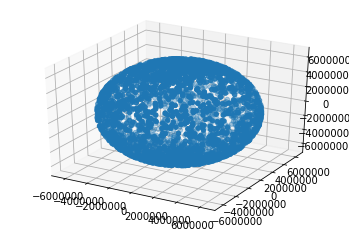

In [165]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X = list(map(lambda x: x[0], coord_list))
Y = list(map(lambda x: x[1], coord_list))
Z = list(map(lambda x: x[2], coord_list))

ax.scatter(X, Y, Z)

In [170]:
kdtree = build_kdtree(points)

In [95]:
a

{'a': 1, 'b': 2}

In [109]:
kdtree = build_kdtree(points)

In [112]:
dist = 300

In [113]:
cdist = haversine_to_euclidean(dist)

In [157]:
def distance(p1, p2):
    return math.sqrt(abs(p1[0]-p2[0])**2+abs(p1[1]-p2[1])**2+abs(p1[2]-p2[2])**2)

In [127]:
def search_neighbours(kdtree, dist, point, depth=0):
    result = set()
    
    axis = depth%3
    
    if distance(kdtree['point']['coords'], point) < dist:
        result.add(kdtree['point']['city'])
        
    if not kdtree['left'] is None:
        if kdtree['point']['coords'][axis] > point[axis] - dist:
            result = result.union(search_neighbours(kdtree['left'], dist, point, depth + 1))
            
    if not kdtree['right'] is None:
        if kdtree['point']['coords'][axis] < point[axis] + dist:
            result = result.union(search_neighbours(kdtree['right'], dist, point, depth + 1))
    
    return result

In [167]:
points

[{'city': 'Abu Dhabi, ae; 1.0',
  'coords': (3378.4150246330823, 4713.124785261086, 2638.637466551835)},
 {'city': 'Dubai, ae; 3.0',
  'coords': (3279.7394371927367, 4737.3785356379185, 2718.4912790369235)},
 {'city': 'Sharjah, ae; 6.0',
  'coords': (3268.907456230553, 4739.135770963636, 2728.4569241557047)},
 {'city': 'Baglan, af; 3.0',
  'coords': (1868.4857966358281, 4794.466856980231, 3756.526239105521)},
 {'city': 'Gardez, af; 36.0',
  'coords': (1882.2010980413318, 4961.690364449862, 3525.420365553222)},
 {'city': 'Gazni, af; 8.0',
  'coords': (1952.6423492519039, 4937.47561679371, 3521.102581504205)},
 {'city': 'Herat, af; 11.0',
  'coords': (2453.2446153844094, 4652.928077927905, 3594.6477099595627)},
 {'city': 'Jalalabad, af; 18.0',
  'coords': (1758.3900512343928, 4952.222325823943, 3601.8327922504677)},
 {'city': 'Kabul, af; 13.0',
  'coords': (1865.5465228071212, 4906.785668911616, 3610.101324146711)},
 {'city': 'Qandahar, af; 23.0',
  'coords': (2231.828428234522, 4945.282

In [168]:
point = (3378.4150246330823, 4713.124785261086, 2638.637466551835)

In [169]:
for i in points:
    if distance(i['coords'], point) < cdist:
        print(i['city'])

Abu Dhabi, ae; 1.0
Dubai, ae; 3.0
Sharjah, ae; 6.0
Doha, qa; 01


In [144]:
cdist

300.02772334748374

In [171]:
search_neighbours(kdtree, cdist, point)

{'Abu Dhabi, ae; 1.0', 'Doha, qa; 01', 'Dubai, ae; 3.0', 'Sharjah, ae; 6.0'}

In [108]:
for node in G.nodes:
    

Abu Dhabi, ae; 1.0


In [116]:
kdtree['point']

{'city': 'Palo Negro, ve; 04',
 'coords': (10719.569367970582, -4665436.5682968125, -4338574.38774898)}

In [117]:
s = set()

In [118]:
s2 = set([1,2])

In [120]:
s.union(s2)

{1, 2}

In [232]:
'''
Utilities to build the graph
'''
def spherical_to_cartesian(coords):
    '''
    Converts spherical coordinates to cartesian coordinates
    '''
    rad_lat, rad_lon = math.radians(coords[0]), math.radians(coords[1])
    
    x = c.EARTH_RADIUS*math.cos(rad_lat)*math.cos(rad_lon)
    y = c.EARTH_RADIUS*math.cos(rad_lat)*math.sin(rad_lon)
    z = c.EARTH_RADIUS*math.sin(rad_lat)
    return x, y, z


def haversine_to_euclidean(dist):
    '''
    Converts haversine dist to euclidean dist
    '''
    R = c.EARTH_RADIUS # earth radius
    gamma = math.acos((2*(R**2) - dist**2) / (2*R**2))
    return gamma * R


def build_kdtree(points, depth=0):
    '''
    Builds a 3-dimensional kdtree to store the cities
    '''
    n = len(points)

    if n <= 0:
        return None

    axis = depth%3

    sorted_points = sorted(points, key=lambda point: point['coords'][axis])

    return {
        'point': sorted_points[int(n/2)],
        'left': build_kdtree(sorted_points[:int(n/2)], depth + 1),
        'right': build_kdtree(sorted_points[int(n/2) + 1:], depth + 1)
    }


def search_neighbours(kdtree, dist, edist, point_cartesian, point_spherical, coordinates, depth=0):
    '''
    Returns a set with all the points nearest
    '''
    result = set()
    
    axis = depth%3
    
    if haversine(coordinates[kdtree['point']['city']], point_spherical) < dist:
        result.add(kdtree['point']['city'])
        
    if not kdtree['left'] is None:
        if kdtree['point']['coords'][axis] > point_cartesian[axis] - edist:
            result = result.union(search_neighbours(kdtree['left'], dist, edist, point_cartesian, point_spherical, coordinates, depth + 1))
            
    if not kdtree['right'] is None:
        if kdtree['point']['coords'][axis] < point_cartesian[axis] + edist:
            result = result.union(search_neighbours(kdtree['right'], dist, edist, point_cartesian, point_spherical, coordinates, depth + 1))
    
    return result


def build_graph(coordinates, dist):
    cartesian_points = [{'city': k, 'coords': spherical_to_cartesian(v)} for k, v in coordinates.items()]

    kdtree = build_kdtree(cartesian_points)

    G = nx.Graph()
    G.add_nodes_from(coordinates.keys())

    for node in G.nodes:
        point_spherical = coordinates[node]
        point_cartesian = spherical_to_cartesian(point_spherical)
        for neighbour in search_neighbours(
            kdtree,
            dist,
            haversine_to_euclidean(dist),
            point_cartesian,
            point_spherical,
            coordinates
        ):
            if node != neighbour:
                G.add_edge(node, neighbour, distance=haversine(coordinates[neighbour], point_spherical))

    return G



In [233]:
import time
start_time = time.time()
G2 = build_graph(coordinates, 300)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.6532800197601318 seconds ---


In [221]:
len(G.edges)

48159

In [234]:
len(G2.edges)

48159

In [236]:
print(G2.edges)

[('Abu Dhabi, ae; 1.0', 'Dubai, ae; 3.0'), ('Abu Dhabi, ae; 1.0', 'Sharjah, ae; 6.0'), ('Dubai, ae; 3.0', 'Sharjah, ae; 6.0'), ('Baglan, af; 3.0', 'Qunduz, af; 24.0'), ('Baglan, af; 3.0', 'Termiz, uz; 12'), ('Baglan, af; 3.0', 'Gazni, af; 8.0'), ('Baglan, af; 3.0', 'Jalalabad, af; 18.0'), ('Baglan, af; 3.0', 'Kabul, af; 13.0'), ('Baglan, af; 3.0', 'Gardez, af; 36.0'), ('Baglan, af; 3.0', 'Dushanbe, tj; 2'), ('Gardez, af; 36.0', 'Gazni, af; 8.0'), ('Gardez, af; 36.0', 'Jalalabad, af; 18.0'), ('Gardez, af; 36.0', 'Kabul, af; 13.0'), ('Gardez, af; 36.0', 'Mardan, pk; 03'), ('Gardez, af; 36.0', 'Dera Ismail Khan, pk; 03'), ('Gardez, af; 36.0', 'Kohat, pk; 03'), ('Gardez, af; 36.0', 'Peshawar, pk; 03'), ('Gazni, af; 8.0', 'Kabul, af; 13.0'), ('Gazni, af; 8.0', 'Jalalabad, af; 18.0'), ('Gazni, af; 8.0', 'Kohat, pk; 03'), ('Gazni, af; 8.0', 'Peshawar, pk; 03'), ('Jalalabad, af; 18.0', 'Qunduz, af; 24.0'), ('Jalalabad, af; 18.0', 'Dera Ismail Khan, pk; 03'), ('Jalalabad, af; 18.0', 'Mingaora, 

In [223]:
g1 = set(G.edges)

In [224]:
g2 = set(G2.edges)

In [226]:
g2.difference(g1)

{('Abu Dhabi, ae; 1.0', 'Doha, qa; 01'),
 ('Bauru, br; 27', 'São Bernardo do Campo, br; 27'),
 ('Cluj-Napoca, ro; 13', 'Focsani, ro; 40'),
 ('Girón, co; 26', 'Soacha, co; 33'),
 ('Jamalpur, bd; 81', 'Bally, in; 28.0')}

In [228]:
get_city_distance('Abu Dhabi, ae; 1.0', 'Doha, qa; 01')

300.003414639297

In [209]:
51691-48159

3532

In [193]:
point = (41.3887901, 2.1589899)

In [194]:
search_neighbours(kdtree, cdist, spherical_to_cartesian(point), point, coordinates)

IndexError: tuple index out of range